<img src="emir_color_853x315_trans.png" alt="EMIR logo" style="float: right; width: 150px;"/>

# Reduction of central spectrum of NGC 7798

Example of reduction of the central spectrum of the galaxy NGC 7798, making use of the response curve previosly derived from the observation of the standard star HD209290.

<img src="esquema_reduccion.png" alt="Reduction scheme" style="float: right; width: 500px; border: 2px solid black; margin: 20px;"/>

The general reduction process is subdivided in two main blocks:

  - `Pyemir` helps to transform the raw data into a 2D rectified and wavelength calibrated image. 

  - The subsequent work, that typically requires taking decisions that in most cases 
    cannot be easily foreseen by an automatic pipeline, can be carried out with the 
    user's favourite software package (i.e. Iraf, MIDAS, idl, python scripts,...).

## Raw data:

Compressed tar.gz file with 6 images: [ngc7798_files.tgz](ngc7798_files.tgz)

```bash
$ tar zxvf ngc7798_files.tgz
$ ls *.fits
0001005178-20160727-EMIR-TEST0.fits  0001005211-20160727-EMIR-TEST0.fits
0001005189-20160727-EMIR-TEST0.fits  0001005222-20160727-EMIR-TEST0.fits
0001005200-20160727-EMIR-TEST0.fits  0001005233-20160727-EMIR-TEST0.fits
```

The content of these files can be rapidly shown using:

```bash
$ dfits 000100*20160727-EMIR-TEST0.fits | fitsort object grism filter exptime date-obs
FILE                               	OBJECT  	GRISM   FILTER EXPTIME   	DATE-OBS              	
0001005178-20160727-EMIR-TEST0.fits	NGC7798 	J       J      119.991601	2016-07-28T04:11:03.88	
0001005189-20160727-EMIR-TEST0.fits	NGC7798 	J       J      119.991601	2016-07-28T04:14:16.98	
0001005200-20160727-EMIR-TEST0.fits	NGC7798 	H       H      119.991601	2016-07-28T04:21:09.38	
0001005211-20160727-EMIR-TEST0.fits	NGC7798 	H       H      119.991601	2016-07-28T04:24:24.59	
0001005222-20160727-EMIR-TEST0.fits	NGC7798 	K       Ksp    119.991601	2016-07-28T04:29:42.10	
0001005233-20160727-EMIR-TEST0.fits	NGC7798 	K       Ksp    119.991601	2016-07-28T04:33:21.57
```

Note that `dfits` and `fitsort` are useful tools to quickly examine the header content of a set of FITS files, which belong to the ESO eclipse library. If you do not have eclipse installed in your system, you can download the following stand-alone files (somehow outdated, but that do not require anything else but a C compiler): [dfits.c](dfits.c) and [fitsort.c](fitsort.c).
*Please, note that these files can be directly compiled using any C compiler (e.g.,* `cc -o dfits dfits.c; cc -o fitsort fitsort.c`*)*.

The CSU configuration can be displayed with:
```bash
$ pyemir-display_slitlet_arrangement 000100*20160727-EMIR-TEST0.fits
```


## Reduction of the galaxy spectra (A - B)

<div class="alert alert-block alert-info">
The following steps are going to be carried out with the grims J + filter J images. For the other settings (grism H + filter H, and grism K + filter Ksp) the steps are similar.
</div>

### Subtraction of consecutive images to remove the sky spectrum:

```bash
$ numina-imath 0001005189-20160727-EMIR-TEST0.fits - 0001005178-20160727-EMIR-TEST0.fits ngc7798_grismJ_A-B.fits
```

The resulting image, `ngc7798_grismJ_A-B.fits` can be easily displayed with ds9 or using:
```bash
$ numina-ximshow ngc7798_grismJ_A-B.fits
```

<img src="reduction_ngc7798/ximshow_ngc7798_grismJ_A-B.png" alt="grismJ_A-B.fits" style="float: left; width: 500px;"/>

The galaxy data appear with positive (white) and negative (black) number of counts. 

### Apply bad-pixel mask

The file `BadPixeMask_F.fits`, containing the bad-pixel mask, is available in the [calibrations](calibrations.html) page.

```bash
$ numina-bpm ngc7798_grismJ_A-B.fits \
  --bpm BadPixMask_F.fits \
  --outfile ngc7798_grismJ_A-B_bpm.fits
```

### Overplot of slitlet boundaries

The detection region spanned by each slitlet can be displayed using:

```bash
$ pyemir-overplot_boundary_model ngc7798_grismJ_A-B_bpm.fits \
  --fitted_bound_param refined_multislit_param_grism_J_filter_J.json \
  --ds9reg_boundaries ds9_boundaries_ngc7798_grismJ_A-B.reg \
  --ds9reg_frontiers ds9_frontiers_ngc7798_grismJ_A-B.reg
```

Note that the optional arguments `--ds9reg_boundaries` or/and `--ds9reg_frontiers` indicate the name of ds9 region files with the boundaries and frontiers of all the slitlets (note that the use of the additional optional parameter `--debugplot 0` would have avoided the plot, generating directly the ds9 region files). 

<img src="reduction_ngc7798/boundary1_ngc7798_grismJ_A-B.png" alt="boundary grismJ_A-B.fits" style="float: left; width: 500px;"/>

<img src="reduction_ngc7798/boundary2_ngc7798_grismJ_A-B.png" alt="boundary zoom grismJ_A-B.fits" style="float: left; width: 500px;"/>

<img src="reduction_ngc7798/boundary3_ngc7798_grismJ_A-B.png" alt="boundary zoom grismJ_A-B.fits" style="float: left; width: 500px;"/>

In this case, the positive spectrum (white) appears in slitlet number 16, whereas the negative spectrum (black) is located in slitlet number 41.

Blue dotted lines indicate frontiers (actual separation between slitlets), whereas cyan and magenta dotted lines show the slitlet regions where the signal is not seriously affected by the reduction of aperture between consecutive slitlets.

### Flatfield (pixel-to-pixel variation)

For this particular observation, we select the file `continuum_ls05_J_J_on-off_flat.fits`,
from the [calibrations](calibrations.html) page, as the pixel-to-pixel variation flatfield.

```bash
$ numina-imath ngc7798_grismJ_A-B_bpm.fits / continuum_ls05_J_J_on-off_flat.fits ngc7798_grismJ_A-B_flat.fits
```

### Rectification and wavelength calibration

<div class="alert alert-block alert-danger">
Please, note that in its current state, this functionality still needs to be improved in order to:
<ul>
    <li> Carry out the rectfication process using an interpolation technique that takes into account fraction of pixels preserving the flux (at present the code uses the nearest-neighbor algorithm, which preserves the flux but leads to a typical zigzag pattern; on the other side, this approach is fast).</li>
    <li> Take into account DTU shifts (that still need to be properly calibrated).</li>
</ul>
In addition, it is important to realize that the method described below makes use of an interpolation technique based on calibration images obtained in a discrete sampling of the CSU configuration.
<br><br>
<b>For all those reasons, it is not unexpected that the absolute wavelength calibration might suffer from small systematic offsets.</b>
</div>

**Step 1**: Using the library of rectification and wavelength calibration transformations corresponding to grism J + filter J (file `rect_wpoly_MOSlibrary_grism_J_filter_J.json`; see [calibrations](calibrations.html) page), we derive the particular polynomials for the current CSU configuration:

```bash
$ pyemir-evaluate_rect_wpoly ngc7798_grismJ_A-B_flat.fits \
  --rect_wpoly_MOSlibrary rect_wpoly_MOSlibrary_grism_J_filter_J.json \
  --out_rect_wpoly coef_rect_wpoly_ngc7798_grismJ_from_mosmodel.json \
  --ignore_DTUconf
```

**Step 2**: Apply the rectification and wavelength calibration polynomials just computed:

```bash
$ pyemir-apply_rect_wpoly ngc7798_grismJ_A-B_flat.fits \
  --coef_rect_wpoly coef_rect_wpoly_ngc7798_grismJ_from_mosmodel.json \
  --outfile ngc7798_grismJ_A-B_rectwv.fits \
  --ignore_DTUconf
```

The wavelength calibration parameters are:
```bash
$ dfits ngc7798_grismJ_A-B_rectwv.fits | fitsort CRVAL1 CDELT1
FILE                          	CRVAL1 	CDELT1	
ngc7798_grismJ_A-B_rectwv.fits	11200.0	0.77  	
```

<div class="alert alert-block alert-warning">
The following sections provide a simple example of spectrum extraction. As previously mentioned, the corresponding tasks can be carried out with any astronomical software package (i.e., Iraf, MIDAS,...).</div>

## Spectrum extraction

This section assumes that the user is going to execute the following Python code either within a jupyter notebook:

```bash
$ jupyter notebook
```

or within an ipython terminal:

```bash
$ ipython
```

In the latter case the `% matplotlib inline` magic command must be ignored, and an additional `plt.show()` command must be used to display each matplotlib plot.

Start by importing the python packages that are going to be needed in the following reduction:

In [1]:
% matplotlib inline

from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import numpy as np

from numina.array.display.ximshow import ximshow

Read the FITS file containing the 2D rectified and wavelength calibrated A-B image:

In [2]:
# read FITS image
with fits.open('ngc7798_grismJ_A-B_rectwv.fits', mode='readonly') as hdulist:
    image_header = hdulist[0].header
    image_data = hdulist[0].data
    
# image dimensions
naxis2, naxis1 = image_data.shape

print('naxis1:', naxis1)
print('naxis2:', naxis2)

naxis1: 3400
naxis2: 2048


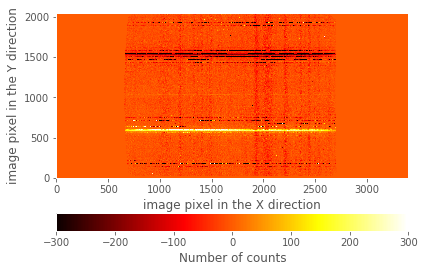

In [3]:
ximshow(image_data, geometry=None, z1z2=(-300,300), debugplot=1)

Note that the rectified and wavelength calibrated image create by the script pyemir-apply_rect_wpoly does not fill the whole image array: there are zeros in the wavelength (i.e. horizontal) direction, before and after the actual location of the data. This has been done in purpose in order to accommodate, in the same wavelength linear scale, all the EMIR images obtained with different CSU configurations (i.e., with the slitlets in different locations along the wavelength direction).

In [4]:
# read wavelength calibration parameters and exposure time from header
crpix1 = image_header['crpix1']
crval1 = image_header['crval1']
cdelt1 = image_header['cdelt1']
exptime = image_header['exptime']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)
print('exptime:', exptime)

crpix1, crval1, cdelt1: 1.0 11200.0 0.77
exptime: 119.991601


Display the image region around the positive galaxy data (slitlet number 16):

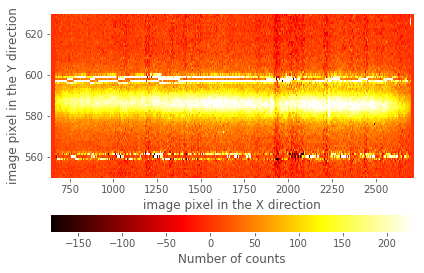

In [5]:
ximshow(image_data, image_bbox=(640,2720,550,630), geometry=None, debugplot=1)

Display the image region around the negative galaxy data (slitlet number 41):

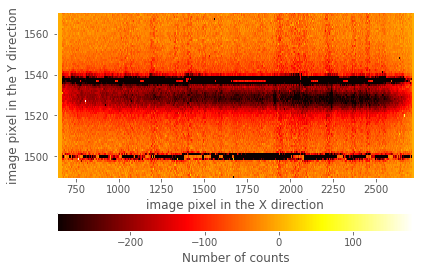

In [6]:
ximshow(image_data, image_bbox=(640,2720,1490,1570), geometry=None, debugplot=1)

Extract and coadd positive and negative spectra by coadding the corresponding image rows:

In [7]:
# positive spectrum, in counts/second
sp1 = np.sum(image_data[575:585,], axis=0) / exptime

# negative spectrum (note the negative sign!), in counts/second
sp2 = -np.sum(image_data[1523:1533,], axis=0) / exptime

# average of the two spectra
spectrum = (sp1 + sp2) / 2

From the file [plot_single_spectrum.py](plot_single_spectrum.py) load an auxiliary function to plot spectrum (this function avoids to repeat code each time one needs to plot the spectrum or portions of it):

In [8]:
from plot_single_spectrum import plot_single_spectrum

Plot whole spectrum:

(<matplotlib.axes._subplots.AxesSubplot at 0x181fef1ef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181fa0a240>)

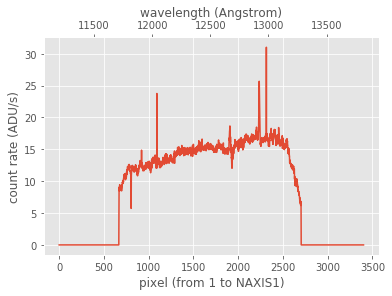

In [9]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    crval1=crval1,
    cdelt1=cdelt1
)

Plot whole spectrum removing leading and trailing zeros:

(<matplotlib.axes._subplots.AxesSubplot at 0x181a7c17b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1816ba15f8>)

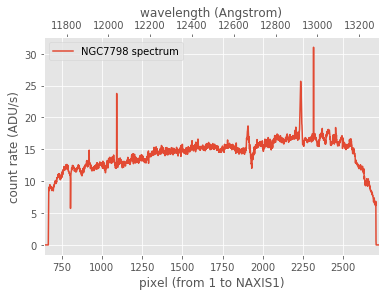

In [10]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[640, 2720],
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

Zooming around pixel affected by cosmetic defects:

(<matplotlib.axes._subplots.AxesSubplot at 0x1816ba2d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181fe82c50>)

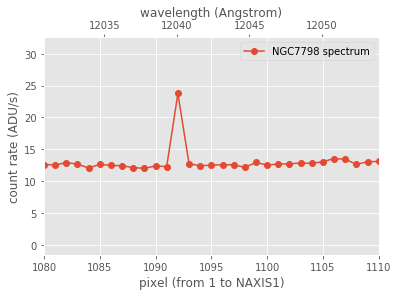

In [11]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[1080, 1110],
    fmt='o-',
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

Replace bad pixels by average of local pixels (remember than numpy array uses 0-based indexing, so it is necessary to subtract 1 from the displayed pixel number):

In [12]:
# define the whole pixel range encompassing the bad pixel region
initial_pixels = np.arange(1087, 1098)
# define pixels which information is going to be replaced
bad_pixels = np.arange(1092, 1093)
# remove from initial range the bad pixels
good_pixels = np.setdiff1d(initial_pixels, bad_pixels)

# display pixel ranges (double checking!)
print('initial_pixels:', initial_pixels)
print('bad_pixels:', bad_pixels)
print('good_pixels:', good_pixels)

# replace the spectrum in the bad pixels by the local mean
# (note: subtacting 1 to follow 0-based indexing)
spectrum[bad_pixels - 1] = np.mean(spectrum[good_pixels - 1])

initial_pixels: [1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097]
bad_pixels: [1092]
good_pixels: [1087 1088 1089 1090 1091 1093 1094 1095 1096 1097]


Display spectrum around cleaned region:

(<matplotlib.axes._subplots.AxesSubplot at 0x181a204748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181a239668>)

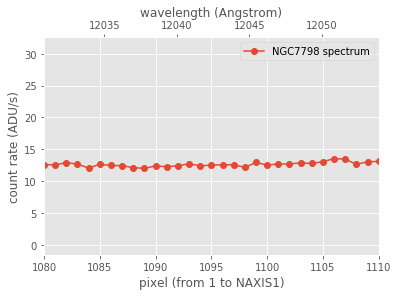

In [13]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[1080, 1110],
    fmt='o-',
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

Repeat cleaning process in next region with bad pixels:

(<matplotlib.axes._subplots.AxesSubplot at 0x181ff51a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181a284208>)

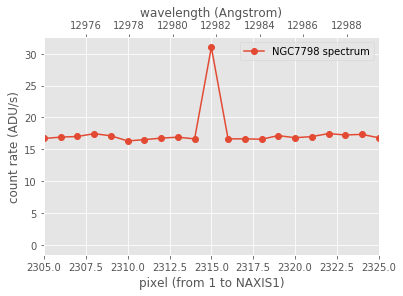

In [14]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[2305, 2325],
    fmt='o-',
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

In [15]:
# define the whole pixel range encompassing the bad pixel region
initial_pixels = np.arange(2310, 2321)
# define pixels which information is going to be replaced
bad_pixels = np.arange(2315, 2316)
# remove from initial range the bad pixels
good_pixels = np.setdiff1d(initial_pixels, bad_pixels)

# display pixel ranges (double checking!)
print('initial_pixels:', initial_pixels)
print('bad_pixels:', bad_pixels)
print('good_pixels:', good_pixels)

# replace the spectrum in the bad pixels by the local mean
# (note: subtacting 1 to follow 0-based indexing)
spectrum[bad_pixels - 1] = np.mean(spectrum[good_pixels - 1])

initial_pixels: [2310 2311 2312 2313 2314 2315 2316 2317 2318 2319 2320]
bad_pixels: [2315]
good_pixels: [2310 2311 2312 2313 2314 2316 2317 2318 2319 2320]


(<matplotlib.axes._subplots.AxesSubplot at 0x181a2f2b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181a3276a0>)

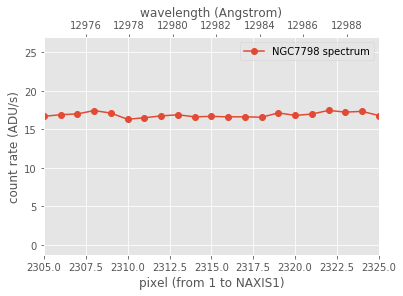

In [16]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[2305, 2325],
    fmt='o-',
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

Display whole spectrum again before saving it:

(<matplotlib.axes._subplots.AxesSubplot at 0x181a3f8898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181a4b0668>)

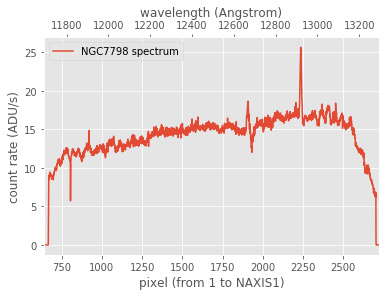

In [17]:
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    pixlimits=[640, 2720],
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

In [18]:
# save spectrum into FITS file
hdu_spectrum = fits.PrimaryHDU(data=spectrum, header=image_header)
hdu_spectrum.writeto('ngc7798_grismJ_spectrum.fits', overwrite=True)

## Flux calibration

Read spectrum to be calibrated (this is the file that we just saved in the last subsection)

naxis : 1
naxis1: 3400
crpix1, crval1, cdelt1: 1.0 11200.0 0.77
exptime: 119.991601


(<matplotlib.axes._subplots.AxesSubplot at 0x180a723470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x180a6d4898>)

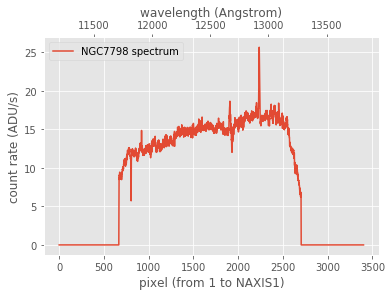

In [19]:
# read FITS image
with fits.open('ngc7798_grismJ_spectrum.fits', mode='readonly') as hdulist:
    image_header = hdulist[0].header
    spectrum = hdulist[0].data
    
print('naxis :', image_header['naxis'])

# image dimension
naxis1 = spectrum.shape[0]
print('naxis1:', naxis1)

# wavelength calibration parameters and exposure time from header
crpix1 = image_header['crpix1']
crval1 = image_header['crval1']
cdelt1 = image_header['cdelt1']
exptime = image_header['exptime']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)
print('exptime:', exptime)

# plot spectrum
plot_single_spectrum(
    spectrum,
    ylabel='count rate (ADU/s)',
    label='NGC7798 spectrum',
    crval1=crval1,
    cdelt1=cdelt1
)

Read the corresponding response curve previously computed using the observatio of HD209290. See details in [Reduction of HD209290](comm2b_hd209290.html). In particular, we are going to use the preliminary response curve, without telluric correction, in order to use the proper telluric absorptions in the response curve as a first-order telluric correction for the galaxy spectrum:

In [20]:
# read response curve
with fits.open('hd209290_grismJ_preliminary_response_curve.fits', mode='readonly') as hdulist:
    response_header = hdulist[0].header
    response_sp = hdulist[0].data

naxis1 = response_sp.shape[0]
print('naxis1:', naxis1)

# read wavelength calibration from header
crpix1 = response_header['crpix1']
crval1 = response_header['crval1']
cdelt1 = response_header['cdelt1']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)

naxis1: 3400
crpix1, crval1, cdelt1: 1.0 11200.0 0.77


It is important to verify that NAXIS1 and the wavelength calibration parameters corresponding to the galaxy spectrum and the response curve do match!

In [21]:
# load auxiliary function to convert from pixel to wavelength
from plot_single_spectrum import funwave

# define wavelength scale for the two spectra
wave = funwave(np.arange(1, naxis1 + 1), crval1=crval1, cdelt1=cdelt1)

From the file [plot_list_spectra.py](plot_list_spectra.py) load an auxiliary function to overplot several spectra: 

(<matplotlib.axes._subplots.AxesSubplot at 0x181a8a99e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x181a8d0b38>)

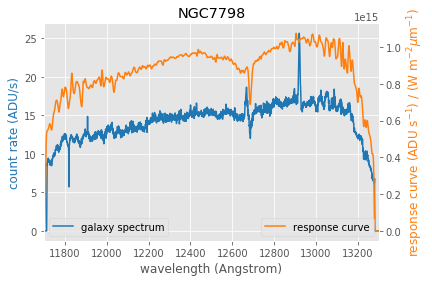

In [22]:
from plot_list_spectra import plot_list_spectra

plot_list_spectra(
    wave, [spectrum, response_sp],
    xlabel='wavelength (Angstrom)',
    list_ylabel=['count rate (ADU/s)',
                 r'response curve (ADU s$^{-1}$) / (W m$^{-2} \mu\rm{m}^{-1}$)'],
    xlimits=[11700, 13300],
    title='NGC7798',
    list_label=['galaxy spectrum', 'response curve']
)

Divide the galaxy spectrum by the response curve (avoiding divisons by zero!):

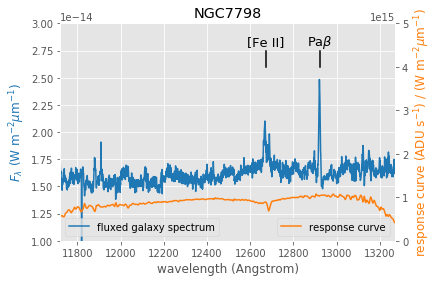

In [23]:
# to avoid division by zero, set response curve to 1.0 where it is <= 0
response_sp[np.where(response_sp <=0)] = 1.0

# flux calibration of the galaxy spectrum
yfluxed = spectrum / response_sp

# display result
ax1, ax2 = plot_list_spectra(
    wave, [yfluxed, response_sp],
    xlabel='wavelength (Angstrom)',
    list_ylabel=[r'$F_\lambda$ (W m$^{-2} \mu\rm{m}^{-1})$',
                 r'response curve (ADU s$^{-1}$) / (W m$^{-2} \mu\rm{m}^{-1}$)'],
    xlimits=[11720, 13270],
    title='NGC7798',
    list_label=['fluxed galaxy spectrum', 
                'response curve']
)

# manual plot limits
ax1.set_ylim([1E-14, 3E-14])
ax2.set_ylim([0, 5E15])


# label emission lines
z = 0.008202  # galaxy redshift
for wline, cline in zip([12568, 12818], [r'[Fe II]', r'Pa$\beta$']):
    xdum = wline*(1+z)
    ax1.plot([xdum, xdum], [2.60E-14, 2.75E-14], 'k-')
    ax1.text(xdum, 2.80E-14, cline, fontsize=13, horizontalalignment='center')

Although the conspicuous telluric feature at $\lambda\sim 12686$ &#8491; has not been perfectly removed in this quick example, this problem has not prevented the clear detection of the nearby \[Fe II\] emission line. A better telluric correction would have required the use of a standard star observed close in time at the same airmass, and with the same spectral resolution. 

In [24]:
%%bash
date

Thu Apr  5 15:34:44 CEST 2018
